# qPCR analysis code

## Import packeges:

In [3]:
import pandas as pd
import numpy as np
from typing import Tuple, List
import os
import matplotlib.pyplot as plt
from scipy import stats
import yaml

In [10]:
def extract_table_from_excel():
    '''
    Read qPCR results from an Excel file, specifically extracting Sample Name, Target Name, and CT values
    from the 'results' sheet to create pandas dataframe.
    
    Parameters:
    -----------
    file_path : str
        Path to the Excel file (.xls or .xlsx)
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing only Sample Name, Target Name, and CT columns
    
    Raises:
    -------
    FileNotFoundError: If the file doesn't exist
    ValueError: If the required sheet or columns are not found
    '''
    '''
    Read qPCR results from Excel file specified in config
    '''
    config = process_from_config("config_file.yaml")
    file_path = config['input_file']
    
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"The file {file_path} does not exist")
            
        if not file_path.endswith(('.xls', '.xlsx')):
            raise ValueError("File must be an Excel file (.xls or .xlsx)")
        
        sheet_name = "Results"
        xls = pd.ExcelFile(file_path)
        sheet_df = pd.read_excel(xls, sheet_name=sheet_name, header=None)

        required_columns = {"Sample Name", "Target Name", "CT"}
        for idx, row in sheet_df.iterrows():
            if required_columns.issubset(set(row)):
                table_start_row = idx
                break
        else:
            raise ValueError("Table headers not found in the sheet")

        table_df = pd.read_excel(
            xls,
            sheet_name=sheet_name,
            skiprows=table_start_row,
            usecols=["Sample Name", "Target Name", "CT"]
        )

        rel_df = table_df[table_df['CT'] != 'Undetermined']
        return rel_df.dropna(how="all").reset_index(drop=True)
        
    except Exception as e:
        print(f"Error reading qPCR results: {str(e)}")
        raise

# Usage:
df = extract_table_from_excel()

In [28]:
print(df)

   Sample Name Target Name         CT
0         DAY0        SOX2  22.966242
1         DAY0        SOX2  22.818962
2         DAY0        SOX2  22.791155
3         DAY0        TBXT   37.43731
4         DAY0        TBXT   34.00279
..         ...         ...        ...
66         NCT        ACTB   36.96955
67         NCT        ACTB  39.826324
68         NRT        SOX2  26.351622
69         NRT        SOX2  26.016064
70         NRT        SOX2  26.340809

[71 rows x 3 columns]


In [14]:
def check_control_samples(rel_df):
    '''
    Check the control samples- NTC (no template control) from the qPCR results. 
    'Undetermined' values in controls indicate clean samples (no contamination).
    Only numeric CT values >= 35 indicate contamination.
    
    Parameters:
    -----------
    rel_df: pd.DataFrame
        The DataFrame that was extracted from the result Excel.
    control_sample_names: list
        List containing the names of control samples (if there are any), as they are showing in the excel result sheet.
    
    Returns:
    --------
    pd.DataFrame
        DataFrame not containing contaminated control samples.

    Raises:
    -------
    ValueError: If the control sample not found.
    ValueError: If CT value of control sample not found.
    ValueError: If control samples have numeric CT values >= 35.
    '''
    '''
    Check control samples (NTC) from qPCR results for contamination.
    Returns DataFrame without contaminated control samples.
    '''
    config = process_from_config("config_file.yaml")
    control_sample_names = config['control_samples']
    
    unclean_targets = []
    error_messages = []
    filtered_df = rel_df[~rel_df['Sample Name'].isin(control_sample_names)].copy()
    
    for control in control_sample_names:
        if control not in rel_df["Sample Name"].values:
            error_messages.append(f"Control sample '{control}' not found in DataFrame")
            continue
            
        control_data = rel_df[rel_df["Sample Name"] == control]
        
        if control_data.empty:
            error_messages.append(f"No CT values found for control sample '{control}'")
            continue
        
        numeric_mask = control_data['CT'] != 'Undetermined'
        contaminated_data = control_data[numeric_mask & (control_data['CT'].astype(float) >= 35)]
        
        if not contaminated_data.empty:
            unclean_targets.extend(contaminated_data['Target Name'].unique().tolist())
    
    if error_messages or unclean_targets:
        warning_text = "\n".join(error_messages)
        if unclean_targets:
            warning_text += f"\nWarning: Control is not clean for targets: {', '.join(unclean_targets)}"
        print(warning_text)
        
    return filtered_df

In [29]:
filtered_df = check_control_samples(df)
print(filtered_df)


   Sample Name Target Name         CT
0         DAY0        SOX2  22.966242
1         DAY0        SOX2  22.818962
2         DAY0        SOX2  22.791155
3         DAY0        TBXT   37.43731
4         DAY0        TBXT   34.00279
5         DAY0        TBXT   37.30759
6         DAY0       HAND1  32.822693
7         DAY0       HAND1  32.729843
8         DAY0       HAND1  31.788738
9         DAY0       PRRX1  31.768803
10        DAY0       PRRX1  33.076084
11        DAY0       PRRX1   32.45987
12        DAY0        ACTB  16.841045
13        DAY0        ACTB   16.66245
14        DAY0        ACTB  16.791422
15        DAY1        SOX2   28.49181
16        DAY1        SOX2    28.3144
17        DAY1        SOX2  28.459536
18        DAY1        TBXT  20.609346
19        DAY1        TBXT  20.417328
20        DAY1        TBXT  20.345217
21        DAY1       HAND1  25.415026
22        DAY1       HAND1  25.357729
23        DAY1       HAND1  25.498245
24        DAY1       PRRX1  29.016031
25        D

In [31]:
def analyze_results(filtered_df):
    '''
    Take the qPCR results from the data frame and calculating the ΔCt,ΔΔCt and fold change for each gene. 
    
    Parameters:
    -----------
    filtered_df : pd.DataFrame
        The output from function "check_control_samples". The data frame contain the qPCR results without controls samples.
    ref_gene_name : str
        The name of the reference gene that is used as control in the expirament. The targets gene will be analyzed according this gene.
    target_gene_name: list
        List containing names of the gene that are being analyzed, as they are showing in the excel result sheet.
    replicas_num:
    Number of replicas that being used in the expirament. If not mantion the defult in 3 replicas. 
        
    Returns:
    --------
    pd.DataFrame
        DataFrame containing for each Sample Name the calculated values: ΔCt,ΔΔCt and fold change.
    
    Raises:
    -------
    ValueError: If the required referance gene not found.
    ValueError: If one of the required tartet genes not found.
    '''
    '''
    Calculate ΔCt, ΔΔCt and fold change for each gene using config parameters
    '''
    config = process_from_config("config_file.yaml")
    ref_gene_name = config['reference_gene']
    target_gene_name = config['target_genes']
    replicas_num = config['replicates']
    
    filtered_df = filtered_df.copy()

    if ref_gene_name not in filtered_df['Target Name'].values:
        raise ValueError(f"Reference gene '{ref_gene_name}' not found in DataFrame")
    
    for target in target_gene_name:
        if target not in filtered_df['Target Name'].values:
            raise ValueError(f"Target gene '{target}' not found in DataFrame")

    filtered_df = filtered_df[filtered_df['CT'] != 'Undetermined']
    
    ref_data = filtered_df.loc[filtered_df["Target Name"] == ref_gene_name]
    if ref_data.empty:
        raise ValueError(f"No data found for reference gene '{ref_gene_name}'")

    reference_averages = ref_data.groupby('Sample Name')['CT'].mean().to_dict()

    filtered_df['Reference_Mean'] = filtered_df['Sample Name'].map(reference_averages)
    filtered_df['ΔCt'] = filtered_df['CT'] - filtered_df['Reference_Mean']

    filtered_df['ΔΔCt'] = np.nan

    for target in target_gene_name:
        target_samples = filtered_df[filtered_df['Target Name'] == target]
        if not target_samples.empty:
            first_sample_delta_ct = target_samples['ΔCt'].iloc[0]
            filtered_df.loc[filtered_df['Target Name'] == target, 'ΔΔCt'] = \
                filtered_df.loc[filtered_df['Target Name'] == target, 'ΔCt'] - first_sample_delta_ct

    filtered_df['Fold Change'] = np.where(
        filtered_df['ΔΔCt'].notna(),
        2 ** (-filtered_df['ΔΔCt']),
        np.nan
    )

    return filtered_df


In [33]:
analyed_df= analys_results(filtered_df, 'ACTB', ['SOX2','TBXT','HAND1','PRRX1'])
print(analyed_df)

   Sample Name Target Name         CT  Reference_Mean        ΔCt       ΔΔCt  \
0         DAY0        SOX2  22.966242       16.764972    6.20127        0.0   
1         DAY0        SOX2  22.818962       16.764972    6.05399   -0.14728   
2         DAY0        SOX2  22.791155       16.764972   6.026183  -0.175087   
3         DAY0        TBXT   37.43731       16.764972  20.672338        0.0   
4         DAY0        TBXT   34.00279       16.764972  17.237818   -3.43452   
5         DAY0        TBXT   37.30759       16.764972  20.542618   -0.12972   
6         DAY0       HAND1  32.822693       16.764972  16.057721        0.0   
7         DAY0       HAND1  32.729843       16.764972  15.964871   -0.09285   
8         DAY0       HAND1  31.788738       16.764972  15.023766  -1.033955   
9         DAY0       PRRX1  31.768803       16.764972  15.003831        0.0   
10        DAY0       PRRX1  33.076084       16.764972  16.311112   1.307281   
11        DAY0       PRRX1   32.45987       16.76497

/var/folders/fn/p448fcfj07j557lxglq7hjxr0000gn/T/ipykernel_10101/4107844064.py:59: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[0.0 -0.14728000000000208 -0.17508700000000132 5.135400666666666
 4.957990666666664 5.103126666666665 3.842676666666666 4.466991666666665
 3.933788666666665 4.040008666666665 4.002371666666665 4.447803666666665]' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  filtered_df.loc[filtered_df['Target Name'] == target, 'ΔΔCt'] = \


In [34]:
def create_bar_plot(analyzed_df):
    '''
    Create a bar plot containing statistical results using a one-way ANOVA test.

    Parameters:
    -----------
    analyzed_df : pd.DataFrame
        The output from the function "analys_results". The data frame contains all calculated values.
    target_gene_name : list
        List containing names of the genes to be analyzed, as they are shown in the excel result sheet.

    Returns:
    --------
    results : dict
        Dictionary containing ANOVA results (F-statistic and p-value) for each gene.
    Bar plots for each target gene grouped by 'Sample Name'.
    '''
    '''
    Create bar plots with statistical analysis using one-way ANOVA test
    '''
    config = process_from_config("config_file.yaml")
    target_gene_name = config['target_genes']
    ref_gene = config['reference_gene']
    
    results = {}

    for gene in target_gene_name:
        gene_data = analyzed_df.loc[analyzed_df['Target Name'] == gene, ['Sample Name', 'Fold Change']]
        grouped_data = gene_data.groupby('Sample Name')['Fold Change'].apply(list).to_dict()
        
        days = sorted(grouped_data.keys())
        gene_values = [grouped_data[day] for day in days]
        
        f_stat, p_val = stats.f_oneway(*gene_values)
        results[gene] = {'f_statistic': f_stat, 'p_value': p_val}
        
        means = [np.mean(values) for values in gene_values]
        sems = [np.std(values, ddof=1) / np.sqrt(len(values)) for values in gene_values]
        
        plt.figure(figsize=(10, 6))
        plt.bar(days, means, yerr=sems, capsize=5, color='skyblue', alpha=0.7, label='Mean ± SEM')
        
        for i, day in enumerate(days):
            plt.scatter([i] * len(gene_values[i]), gene_values[i], color='black', alpha=0.5, zorder=3)
        
        plt.yscale('log')
        plt.xticks(ticks=range(len(days)), labels=days)
        plt.ylabel(f'Fold change in {gene}/{ref_gene}')
        plt.title(f'Expression Levels for {gene}\nANOVA p-value: {p_val:.4e}')
        
        if p_val < 0.05:
            plt.text(0.5, 0.95, '*p < 0.05', transform=plt.gca().transAxes, 
                     ha='center', va='center', fontsize=12, color='red')
        
        plt.legend()
        plt.show()
        
        print(f"\nResults for {gene}:")
        print(f"F-statistic: {f_stat:.4f}")
        print(f"p-value: {p_val:.4e}")
        
        if p_val < 0.05:
            print("\nMean expression values:")
            for day, mean in zip(days, means):
                print(f"{day}: {mean:.3f}")

    return results


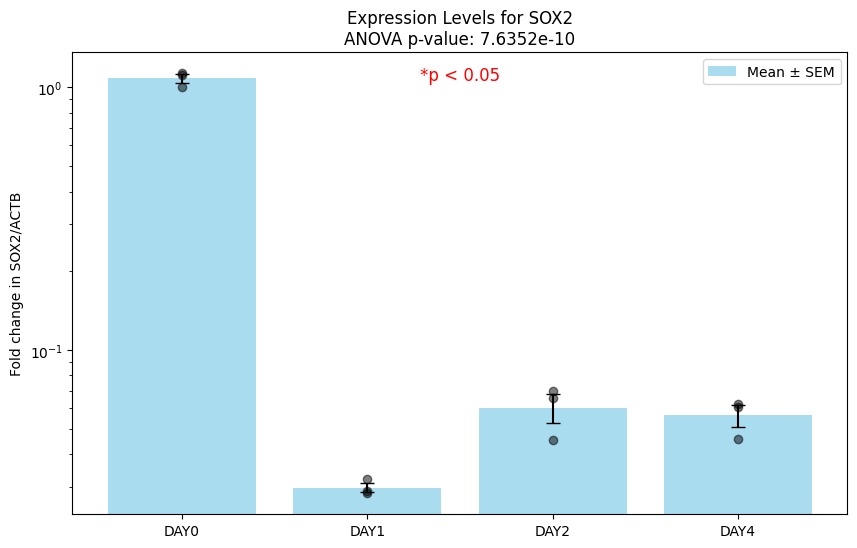


Results for SOX2:
F-statistic: 632.4546
p-value: 7.6352e-10

Mean expression values:
DAY0: 1.079
DAY1: 0.030
DAY2: 0.060
DAY4: 0.056


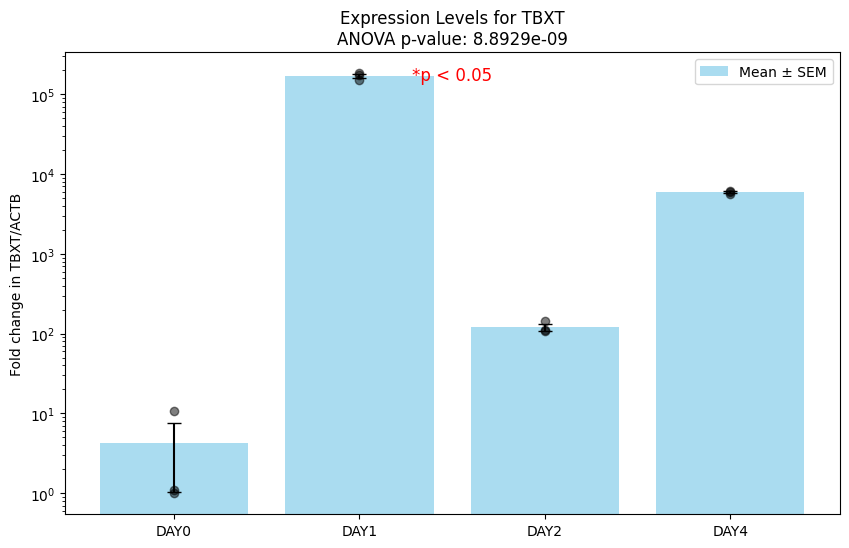


Results for TBXT:
F-statistic: 341.0064
p-value: 8.8929e-09

Mean expression values:
DAY0: 4.302
DAY1: 169912.123
DAY2: 121.316
DAY4: 5946.670


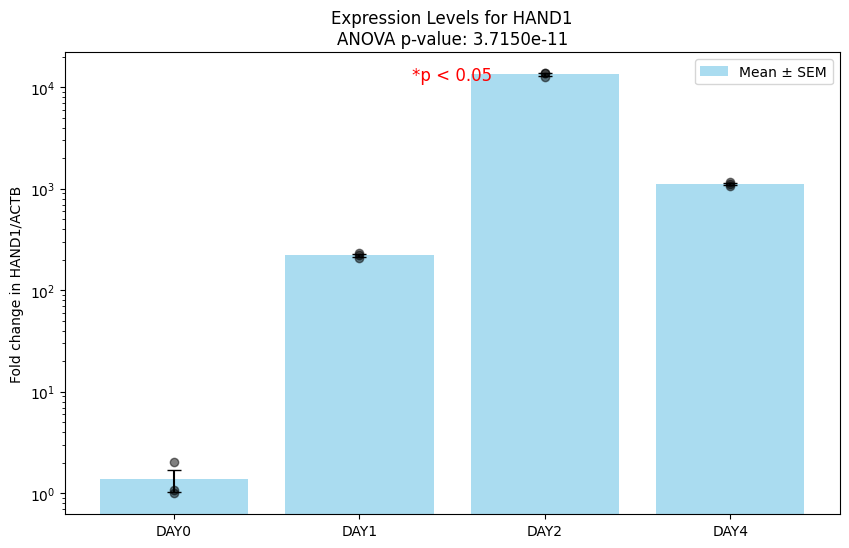


Results for HAND1:
F-statistic: 1349.9284
p-value: 3.7150e-11

Mean expression values:
DAY0: 1.371
DAY1: 221.374
DAY2: 13383.634
DAY4: 1108.089


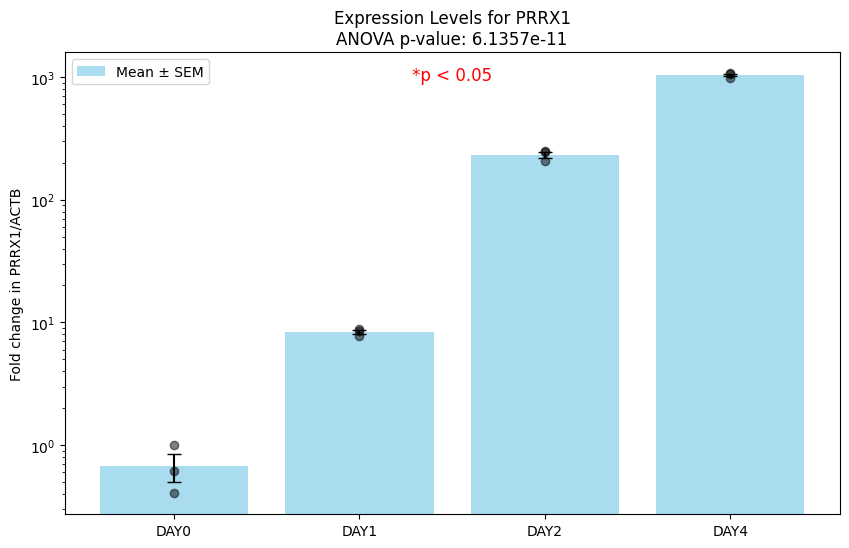


Results for PRRX1:
F-statistic: 1190.4452
p-value: 6.1357e-11

Mean expression values:
DAY0: 0.674
DAY1: 8.370
DAY2: 232.772
DAY4: 1041.337
{'SOX2': {'f_statistic': np.float64(632.4545699026459), 'p_value': np.float64(7.635163430131742e-10)}, 'TBXT': {'f_statistic': np.float64(341.006421339112), 'p_value': np.float64(8.892854624283044e-09)}, 'HAND1': {'f_statistic': np.float64(1349.9284068591232), 'p_value': np.float64(3.7150233191146965e-11)}, 'PRRX1': {'f_statistic': np.float64(1190.445231898355), 'p_value': np.float64(6.135672675578221e-11)}}


In [37]:
bar_plot=create_bar_plot(analyed_df)
print(bar_plot)

In [1]:
def process_from_config(config_path):
    """
    Read and process qPCR configuration file
    Args:
        config_path (str): Path to YAML configuration file
    Returns:
        tuple: Processed configuration parameters
    """
    with open(config_path) as stream:
        config = yaml.safe_load(stream)
    
    # Extract all parameters
    input_file = config["input_file"]
    ref_gene = config["reference_gene"]["name"]
    target_genes = [gene["name"] for gene in config["target_genes"]]
    control_samples = [ctrl["name"] for ctrl in config["control"]]
    replicates = config["replicates"]["number"]
    
    return {
        "input_file": input_file,
        "ref_gene": ref_gene,
        "target_genes": target_genes,
        "control_samples": control_samples,
        "replicates": replicates,
        "technical_replicates": config["replicates"]["technical"]
    }

In [27]:
#Usage example:
config = process_from_config("/Users/lihierez/Python course/qPCR-Results-Analysis/config_file.yaml")
print(config)  # Verify the output structure
#process_data(**config)

{'input_file': '/Users/lihierez/Documents/Weizmann Msc/Rotations/Eyal Kartzburn lab/EXP1_mesencyme_121024_QuantStudio 12K Flex_export.xlsx', 'reference_gene': 'ACTB', 'target_genes': ['SOX2', 'TBXT', 'HAND1', 'PRRX1'], 'control_samples': ['NCT', 'NRT'], 'replicates': 3, 'technical_replicates': True}
